# Hodgkin-Huxley Neuron Simulation with TensorFlow
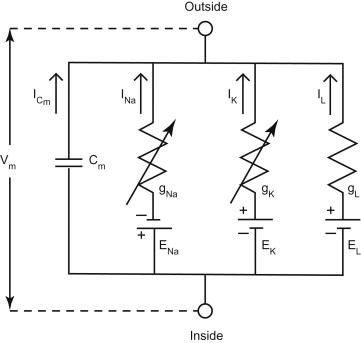

This notebook implements the **Hodgkin-Huxley model**, which describes how action potentials in neurons are initiated and propagated.

We use **TensorFlow 1.x (compat)** to build a custom Ordinary Differential Equation (ODE) solver. This allows us to leverage TensorFlow's computational graph for efficient, vectorized integration, which is particularly useful when simulating multiple neurons simultaneously.

**The Model Equations:**
$$C_m \frac{dV}{dt} = I_{ext} - g_{Na} m^3 h (V - E_{Na}) - g_{K} n^4 (V - E_{K}) - g_{L} (V - E_{L})$$

Where $m$, $h$, and $n$ are gating variables that evolve according to their own differential equations based on voltage-dependent rate constants $\alpha$ and $\beta$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

def tf_type_check(t, y0):
    """Ensure t and y0 are floating point tensors."""
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError("t and y0 must be floating point tensors")

class _Tf_Integrator_functions:
    """RK4 integrator implemented with tf.scan."""

    def integrate(self, func, y0, t):
        dt_grid = t[1:] - t[:-1]

        def scan_loop(y_prev, dt):
            t_curr, dt = dt
            y_prev = tf.reshape(y_prev, [-1])
            dy = self.step_fn(func, y_prev, t_curr, dt)
            return y_prev + dy

        y = tf.scan(scan_loop, (t[:-1], dt_grid), initializer=y0)
        return tf.concat([[y0], y], axis=0)

    def step_fn(self, func, y, t, dt):
        """Standard RK4 step."""
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, dtype=y.dtype)

        k2 = func(y + dt_cast / 2 * k1, half_step)
        k3 = func(y + dt_cast / 2 * k2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)

        dy = tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
        return dy

def final_ode_int(func, y0, t):
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_type_check(t, y0)
    return _Tf_Integrator_functions().integrate(func, y0, t)

print("Integrator ready.")


Integrator ready.


In [ ]:
# Parameters
C_m  = 1.0
g_Na = 120.0
g_K  = 36.0
g_L  = 0.3
E_Na = 50.0
E_K  = -77.0
E_L  = -54.387

# Gating variable helpers
def ion_K_prop(V):
    T = 22
    phi = 3.0**((T - 36.0) / 10)
    V_ = V - (-50)
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    return n_0, t_n

def ion_Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V - (-50)
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    return m_0, t_m, h_0, t_h

# Ion currents
def I_ionK(V, n):
    return g_K * n**4 * (V - E_K)

def I_ionNa(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

# ODE system: X = [V, n, m, h]
def dx_dt(X, t):
    V = X[0:1]
    n = X[1:2]
    m = X[2:3]
    h = X[3:4]

    n_0, t_n = ion_K_prop(V)
    m_0, t_m, h_0, t_h = ion_Na_prop(V)

    I_ext = 5.0

    dVdt = (I_ext - I_ionNa(V, m, h) - I_ionK(V, n) - I_L(V)) / C_m
    dmdt = - (1.0/t_m)*(m - m_0)
    dhdt = - (1.0/t_h)*(h - h_0)
    dndt = - (1.0/t_n)*(n - n_0)

    return tf.concat([dVdt, dndt, dmdt, dhdt], axis=0)


I0000 00:00:1770136086.233099    6005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1770136086.251395    6005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1770136086.258743    6005 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


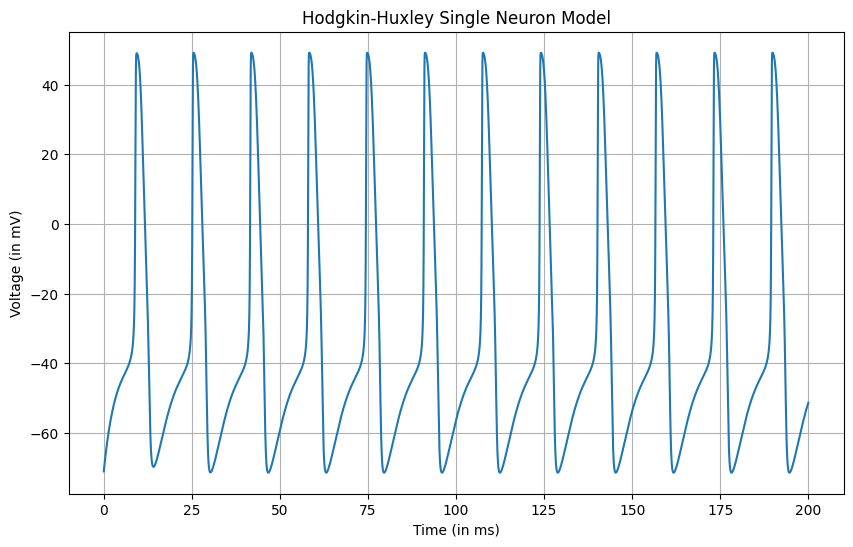

In [3]:
# Initial conditions: [Voltage, n, m, h]
y0_single = tf.constant([-71.0, 0.0, 0.0 ,0.0], dtype=tf.float64)

# Time setup
epsilon = 0.01 
t_single = np.arange(0, 200, epsilon)

# Build the Graph
state_tensor_single = final_ode_int(dx_dt, y0_single, t_single)

# Run Session
with tf.Session() as sess:
    state_result_single = sess.run(state_tensor_single)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_single, state_result_single[:, 0])
plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")
plt.title("Hodgkin-Huxley Single Neuron Model")
plt.grid(True)
plt.show()

## Part 2: Parallel Multi-Neuron Simulation
In this experiment, we simulate **20 neurons** in parallel.
Each neuron receives a linearly increasing input current (from 0.0 to 9.5).

This demonstrates the **All-or-None** principle: Neurons receiving current below a certain threshold do not fire, while those above it generate action potentials.

In [4]:
n_n = 20 # Number of neurons

# Vectorized Parameters (lists of length 20)
C_m_vec = [1.0]*n_n
g_K_vec = [10.0]*n_n
E_K_vec = [-95.0]*n_n

g_Na_vec = [100]*n_n
E_Na_vec = [50]*n_n

g_L_vec = [0.15]*n_n
E_L_vec = [-55.0]*n_n

# --- Vectorized Helper Functions ---
def K_prop_vec(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)

    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)

    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    return n_0, t_n

def Na_prop_vec(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)

    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)

    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)

    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)

    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    return m_0, t_m, h_0, t_h

def I_K_vec(V, n):
    return g_K_vec * n**4 * (V - E_K_vec)

def I_Na_vec(V, m, h):
    return g_Na_vec * m**3 * h * (V - E_Na_vec)

def I_L_vec(V):
    return g_L_vec * (V - E_L_vec)

# --- Vectorized ODE System ---
def dXdt_vec(X, t):
    # Unpack flattened state vector
    # Structure: [V_1...V_20, m_1...m_20, h_1...h_20, n_1...n_20]
    V = X[:1*n_n]
    m = X[1*n_n:2*n_n]
    h = X[2*n_n:3*n_n]
    n = X[3*n_n:]

    # Calculate Current Injection (Linear increase across neurons)
    I_inj = np.linspace(0, 10, n_n)
    
    dVdt = (I_inj - I_Na_vec(V, m, h) - I_K_vec(V, n) - I_L_vec(V)) / C_m_vec

    m0, tm, h0, th = Na_prop_vec(V)
    n0, tn = K_prop_vec(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt, dmdt, dhdt, dndt], 0)
    return out

I0000 00:00:1770136286.368292    6005 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Simulation complete. Generating plots...


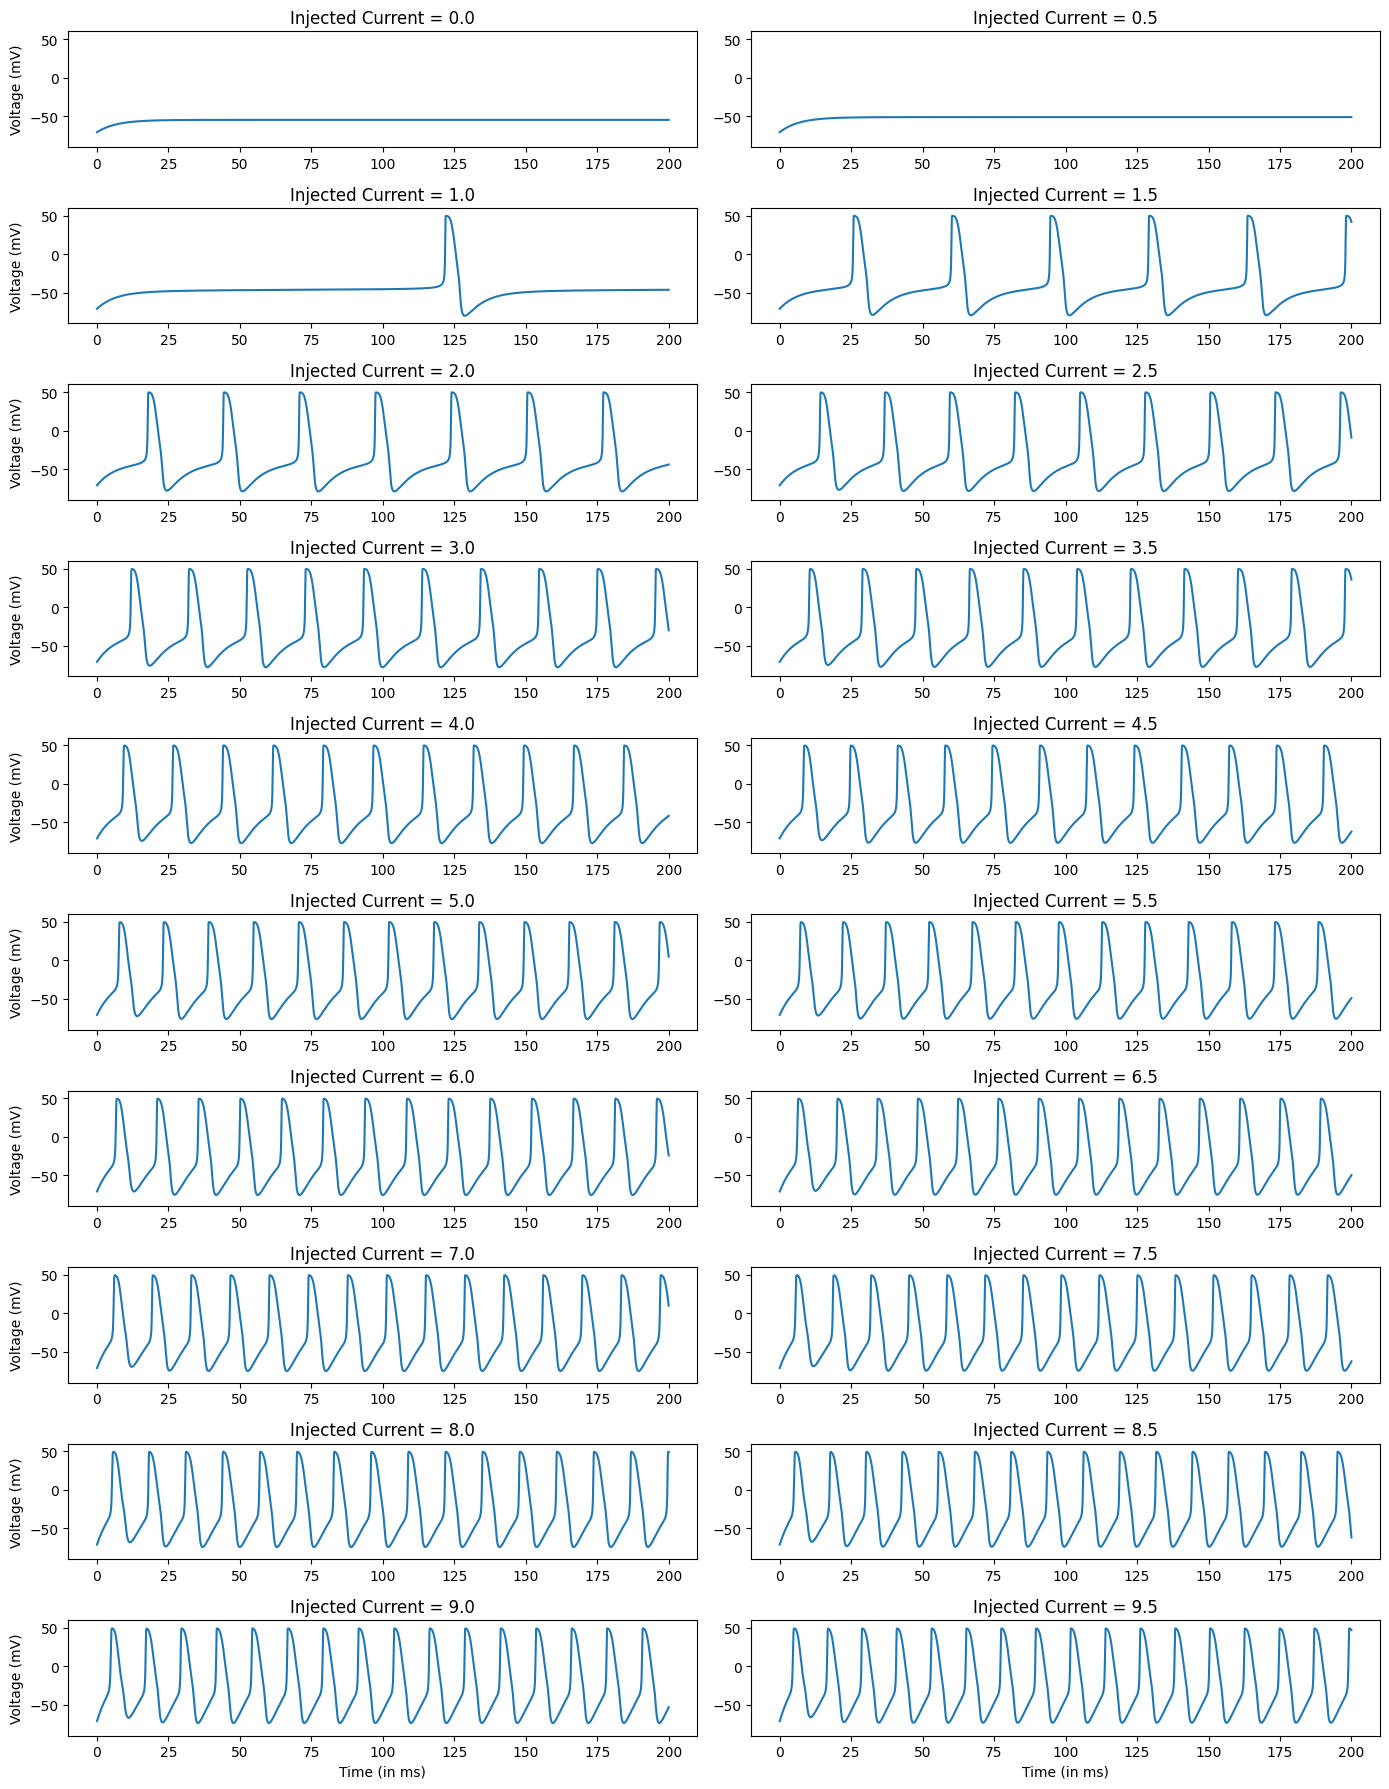

In [ ]:
# initial conditions: [V_1..V_n, m_1..m_n, h_1..h_n, n_1..n_n]
y0_vec = tf.constant(
    np.concatenate([np.full(n_n, -71.0), np.zeros(n_n), np.zeros(n_n), np.zeros(n_n)]),
    dtype=tf.float64
)

# time
epsilon = 0.01
t_vec = np.arange(0, 200, epsilon)

# build & run
state_tensor_vec = final_ode_int(dXdt_vec, y0_vec, t_vec)
with tf.Session() as sess:
    state_result_vec = sess.run(state_tensor_vec)

# plot
print("Simulation complete. Generating plots...")
plt.figure(figsize=(14, 18))
for i in range(n_n):
    plt.subplot(10, 2, i+1)
    plt.plot(t_vec, state_result_vec[:, i])
    plt.title("Injected Current = {:0.1f}".format(i/2))
    plt.ylim([-90, 60])
    if i >= n_n - 2:
        plt.xlabel("Time (in ms)")
    if i % 2 == 0:
        plt.ylabel("Voltage (mV)")

plt.tight_layout()
plt.show()


# Conclusions

In this notebook, we successfully implemented the **Hodgkin-Huxley model** using a custom ODE solver built on TensorFlow 1.x.

### Key Takeaways:

1.  **Computational Efficiency:**
    By leveraging TensorFlow's `tf.scan` and computational graph, we were able to vectorize the differential equations. This allowed us to simulate **20 independent neurons** in parallel without writing an explicit Python loop for each one, demonstrating significant efficiency gains for large-scale biological simulations.

2.  **Biological Insights (The All-or-None Law):**
    * **Experiment 1** showed the classic action potential shape (depolarization, repolarization, and hyperpolarization) for a single neuron.
    * **Experiment 2** demonstrated the threshold property of neurons.
        * **Low Current ($I < 2.0$):** The membrane potential rises but fails to reach the threshold; no spike occurs.
        * **High Current ($I > 2.0$):** The neuron consistently fires repetitive action potentials. The frequency of firing increases as the input current increases.

3.  **Flexibility:**
    This approach can be easily extended to simulate coupled networks of neurons (e.g., by adding synaptic current terms $I_{syn}$ to the voltage equation) to study synchronization and emergent behavior in neural circuits.